In [1]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random

In [2]:
include("rollout.jl")
include("testfns.jl")

TestGramacyLee (generic function with 1 method)

In [3]:
# Global parameters
MC_SAMPLES = 150
BUDGET = 1
HORIZON = 1

1

In [6]:
# Setup toy problem
testfn = TestAckley(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

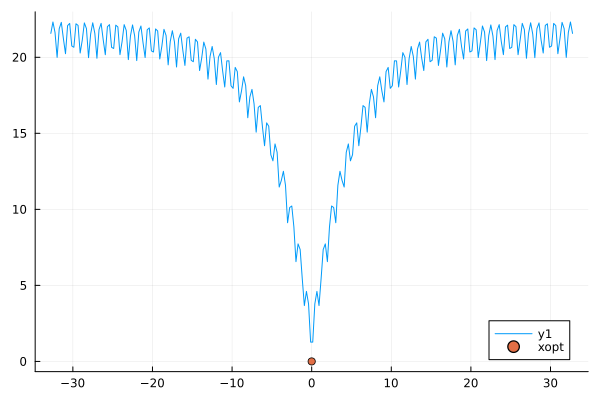

In [7]:
tplot(testfn)

In [131]:
# Gather initial samples/experimental data
N, θ = 1, [1.]
X = [-25.5, 5., 17.3, 19.3]
X = reshape(X, 1, length(X))
# X = range(-30, 30, length=15)'
# X = Matrix(X)
ψ = kernel_matern52(θ);
y = [testfn.f(x) for x in eachcol(X)];
ymean = mean(y)
y = y .- ymean

4-element Vector{Float64}:
  2.781179837912198
 -6.804876441493937
  1.9082306768376043
  2.115465926744129

In [132]:
sur = fit_surrogate(ψ, X, y);
θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, y);

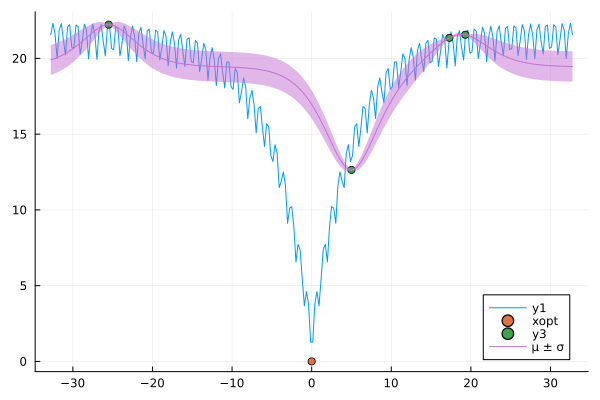

In [135]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
tplot(testfn)
scatter!(sur.X', y .+ ymean)
plot!(domain, [sur([x]).μ .+ ymean for x in domain],
    ribbons=[sur([x]).σ for x in domain], label="μ ± σ")

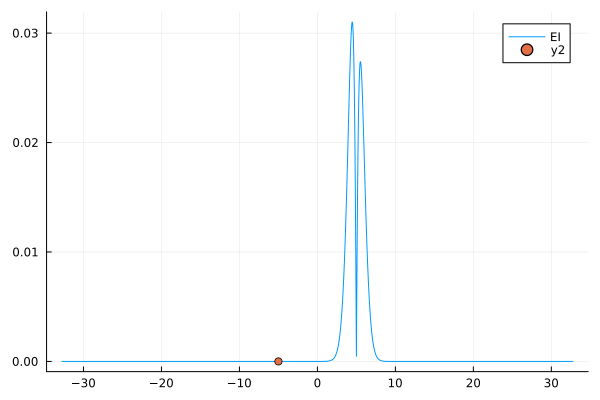

In [153]:
plot(domain, [sur([x]).EI for x in domain], label="EI")
scatter!(Optim.minimizer(result), [0.])

In [155]:
ei(x) = -sur(x).EI
for x0 in -30:2.:30
    result = optimize(ei, [x0], BFGS())
    println("Minimizer: $(Optim.minimizer(result))")
end

Minimizer: [-30.0]
Minimizer: [-28.0]
Minimizer: [-26.0]
Minimizer: [-24.0]
Minimizer: [-22.0]
Minimizer: [-20.0]
Minimizer: [-18.0]
Minimizer: [-16.0]
Minimizer: [-14.0]
Minimizer: [-12.0]
Minimizer: [-10.0]
Minimizer: [-8.0]
Minimizer: [-6.0]
Minimizer: [-4.0]
Minimizer: [-2.0]
Minimizer: [5.51640039912553]
Minimizer: [4.467928351944721]
Minimizer: [4.46792836790571]
Minimizer: [5.516400382019829]
Minimizer: [5.516400378822109]
Minimizer: [5.516400393377854]
Minimizer: [12.0]
Minimizer: [14.0]
Minimizer: [16.0]
Minimizer: [18.0]
Minimizer: [20.0]
Minimizer: [22.0]
Minimizer: [24.0]
Minimizer: [26.0]
Minimizer: [28.0]
Minimizer: [30.0]


In [152]:
Optim.minimizer(result)

1-element Vector{Float64}:
 -5.0

## Maximizing Expected Improvement Polynomial Interpolant

Maximizing our function $f(x)$ consist of finding $\bar{x}$ s.t. $f(\bar{x})$ is greater than all other evaluations of $f(x)$ in our domain. We first construct a polynomial interpolant given $n$ data points. The learned polynomial will be of degree $k=n-1$ and the gradient of said polynomial will be of degree $\bar{k}=k-1$. We can then learn the gradient of the polynomial and use a zero-finding method. We find the zeros by constructing the companion matrix of the gradient. Using a standard eigen solver, the eigenvalues of this matrix corresponds to the zeros of the gradient. Now we take the zeros and evaluate the original polynomial at that location to determine the maximum (evaluate at the bounds as well). 

### Setup Polynomial Interpolant of Expected Improvement
The interpolant shouldn't be sensitive to nearby locations having the same function value. The polynomial interpolant using a monomial basis demonstrates this issue. It seems to be senstive to this.

### Questions
* Is it possible to have exact polynomial interpolation for an arbitrary number of points on some arbitrary interval in 1D? It reminds me of the Kurtis theorem in functional analysis? Check Kernel methods book

In [ ]:
function monomial(j)
    ϕ(t) = t^(j-1)
    return ϕ
end

function polynomial(n)
    monos = [monomial(k) for k in 1:n]
    p(t) = [m(t) for m in monos]
    return p
end

function Vandermonde(ts; degree)
    p = polynomial(degree)
    V = p(first(ts))'
    
    for i in 2:length(ts)
        V = vcat(V, p(ts[i])')
    end
    
    return V
end

Vandermonde(ts) = Vandermonde(ts; degree=length(ts))
coefficients(A, y) = A \ y

function CompanionMatrix(coeffs)
    n = length(coeffs)
    C = zeros(n, n)
    
    # Set subdiagonal to ones
    for i = 2:n
        C[i,i-1] = 1
    end
    
    # Set last column to polynomial coefficients
    for i = 1:n
        C[i,n] = -coeffs[i]
    end
    
    return C
end

In [ ]:
SAMPLE_SIZE = 20
domain = filter(
    x -> !(x in sur.X),
    range(-10, 30, length=SAMPLE_SIZE)
)
sample_values = [sur([x]).EI for x in domain]
scatter(domain, sample_values)

In [ ]:
V = Vandermonde(domain)
coeffs = coefficients(V, sample_values)
p = polynomial(length(domain))
plot(domain, [dot(p(d), coeffs) for d in domain], label="Polynomial Interpolant")
scatter!(domain, sample_values, label="Sample Locations")